In [14]:
from IPython.display import Image

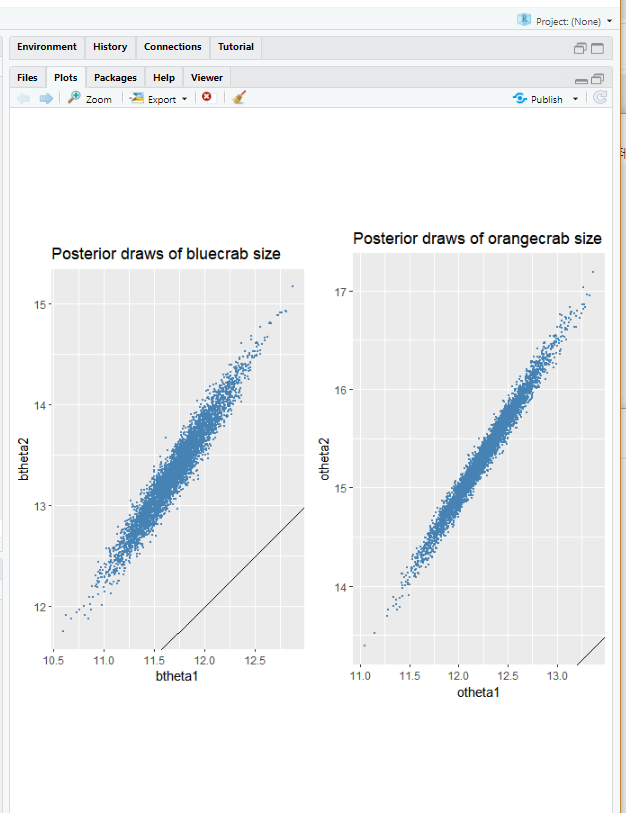

In [15]:
Image('1.PNG')

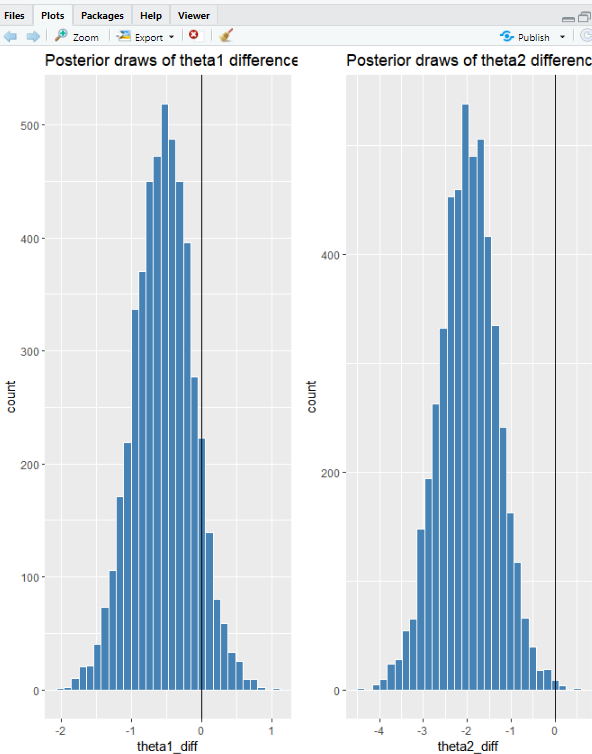

In [16]:
Image('2.PNG')

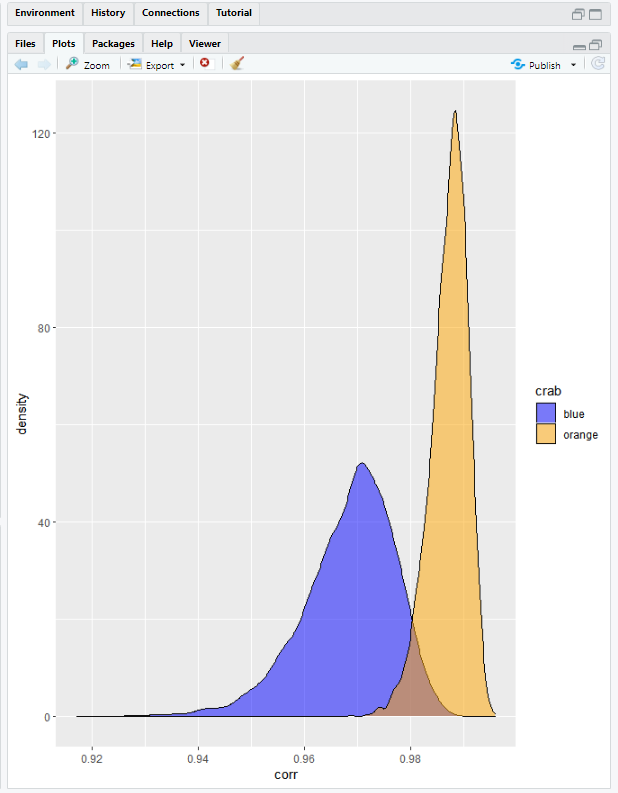

In [17]:
Image('3.PNG')

## **Gibbs Sampling**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Gibbs Sampling Mechanism (.gif 생성)

- 내 환경에서는 gif 가 생성이 안되나..?

In [5]:
import numpy as np
import matplotlib.pyplot as plt

!pip install -U gif
!pip install "gif[matplotlib]"
import gif
from IPython.display import Image
from random import random

  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4817 sha256=ac9ad26ec82e7a3619c433714e2ac798670e2cfcc17e0ba386a3f1c7746cccf8
  Stored in directory: c:\users\goran\appdata\local\pip\cache\wheels\21\63\09\b1e3c512d244da0a7c1d9565f09592612d04b79ccbb95146ae
Successfully built gif


In [6]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index 
    a = cov[sampling_index, sampling_index] # Sigma00
    b = cov[sampling_index, conditioned_index]  # Sigma01
    c = cov[conditioned_index, conditioned_index]  # Sigma11
    
    mu = mean[sampling_index]+(b*current_x[conditioned_index]-mean[conditioned_index])/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x

In [7]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):
    """
    [input 형태]z
    initial_point = [x_0, x_1] = [-9.0, -9.0]
    num_samples = 100
    mean = np.array([0, 0])
    cov = np.array([[10, 3], 
                    [3, 5]])
    """
    frames = []  # for GIF
    
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  # sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) # inbetween points (중간저장소)

    for i in range(num_samples):
        # 요 for loop이 gibbs sampler 핵심
        # point = [x_0, x_1]
        
        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

In [8]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

### Execution

In [9]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])

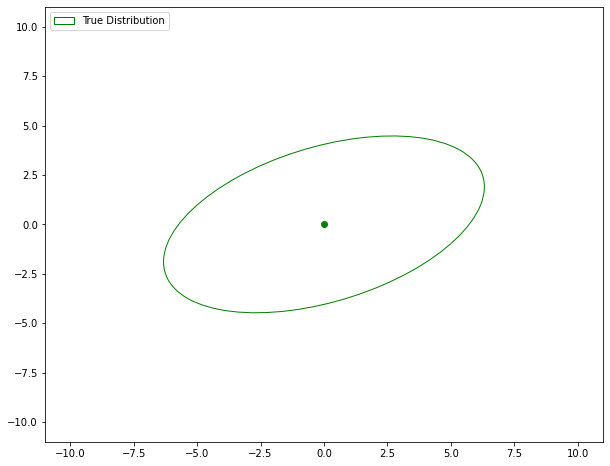

In [10]:
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

## NA imputation using Gibbs Sampler
  
reference : https://www.bingyune.com/blog/diabetes-risk-missing  
theoretical background : https://www.youtube.com/watch?v=c8BXryRibr8, FCB 7.5   
  
### Missing At Random  
Complete data Y = {y_obs, y_mis}  
Response Indicator Oi = 1 (if y_obs) / 0 (if y_mis)  
  
**Assumption** : Ignorable Missing  
(ex. 값이 100 이상이면 결측치로 두겠다 이런 경우는 무시 불가. 조사자/ 연구자의 어떤 의도가 들어갔으니까! 그래서 결측인지 아닌지를 나타내는 indicator variable이 condition된 어떤 변수가 있는 상황임. 그렇지만 그냥 실수로 빼먹은 경우라면 무시 가능! 우리는 데이터의 결측치가 이러한 랜덤한 결측치라고 생각하고 Imputation을 할 예정)

In [2]:
# pip install missingno

In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

**dataset : pima indian diabetes dataset**  
나름 유명해서 캐글, 미국 대학 coursework 사이트에서 여러 버전 찾을 수 있음 (full, missing, etc.)

In [20]:
diabetes = pd.read_csv('./diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

아래를 보면 0이 진짜 의미가 있는 0과 결측치 0이 있는 것을 알 수 있다. 이런 건 우리가 domain knowledge나 EDA를 통해서 적절히 구분해주어야 함!  
  
ex. Pregnancies가 0이란 건 말이 됨. 남성이거나 나이가 어린 여성 등 충분히 임신 횟수가 0일 수 있음!
그렇지만 Glucose, BloodPressure, SkinThickness, Insulin, BMI가 0인 경우는 missing data가 있는 상황이라고 볼 수 있다. 이렇게 말이 안되는 feature들의 0 값들을 NaN으로 바꿔주자!

In [22]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [23]:
# Mark invalid zero values as NaN (null)
temp_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']  
diabetes[temp_cols] = diabetes[temp_cols].replace(0, np.nan)
print(diabetes.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### Visualization  
각 feature 별로 missing data가 얼마나 많은지를 바코드 형태로 시각화해보자!  
R에서는 대표적인 NA imputation package로 MICE 등이 있고,
Python에서 지원하는 패키지로는 missingno, sklearn, pandas, fancyimpute, statsmodel.imputation.mice 등이 있다.  
일단 본 노트북에서는 패키지 없이 manual implementation으로 imputation하는 방법에 대해서 공부해봅시다 :)

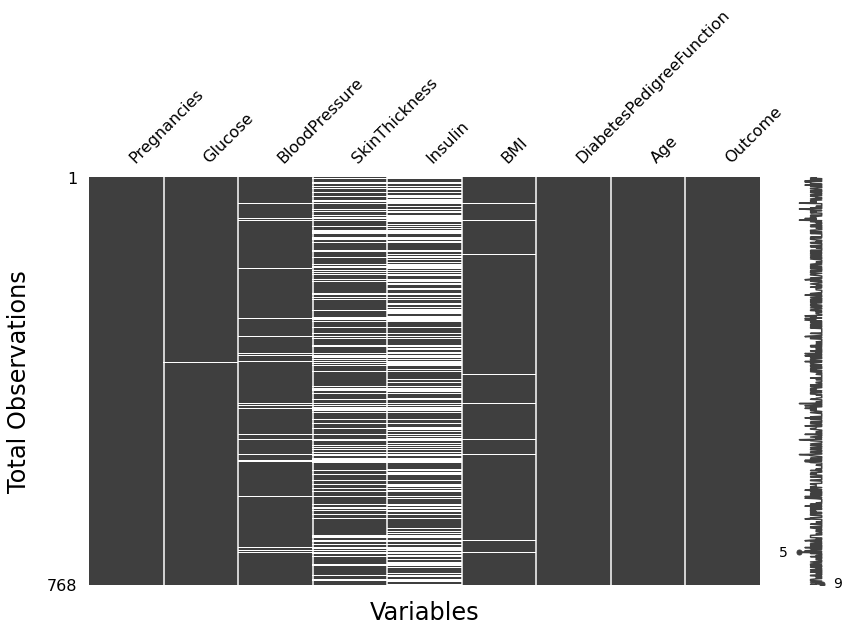

In [24]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(diabetes, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

그럼 왜 굳이 Gibbs Sampler를 통해 NA imputation을 해야 할까?  
아래 heatmap을 보면 알 수 있듯이 variable 간에 correlation이 존재하기 때문에 각각 독립이라고 두고 sampling할 수 없다.
이번 주에 배웠듯이 Gibbs Sampler를 통해 Multivariate case를 쉽게 sampling할 수 있기 때문에 이런 Multivariate case에 적용할 수 있는 것이다.

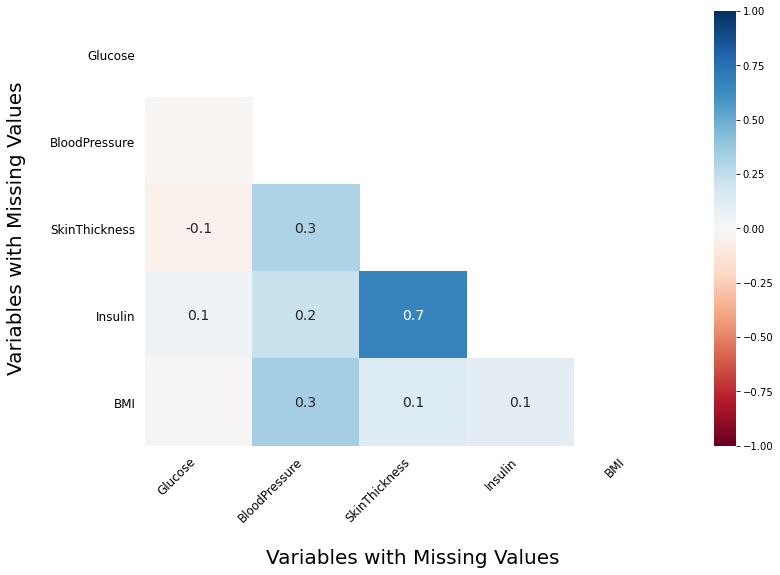

In [25]:
# Visualize the number of missing values as a heatmap
fig = msno.heatmap(diabetes, inline=False, figsize=(12,8))

# Add labels
plt.xlabel('Variables with Missing Values', size=20, labelpad=24)
plt.ylabel('Variables with Missing Values', size=20, labelpad=24)
plt.tick_params(axis='both', labelsize=12, length=6)

plt.show();

NaN이 그대로 남아있는 상태에서 pairplot을 그리면 다음과 같다. 대충 모든 변수가 정규분포를 따른다고 보고 MVN sampling을 적용해보자.  
그렇게 되면 각각의 row는 MVN dist를 따른다고 볼 수 있는 셈이다.  
  
correlation이 없는 변수도 있지만, 있는 변수들도 분명히 존재한다는 사실을 알 수 있다!  
(plot을 그릴 때 missing value가 있는 상태로 그리기 때문에 warning message가 출력된다. 무시 가능)

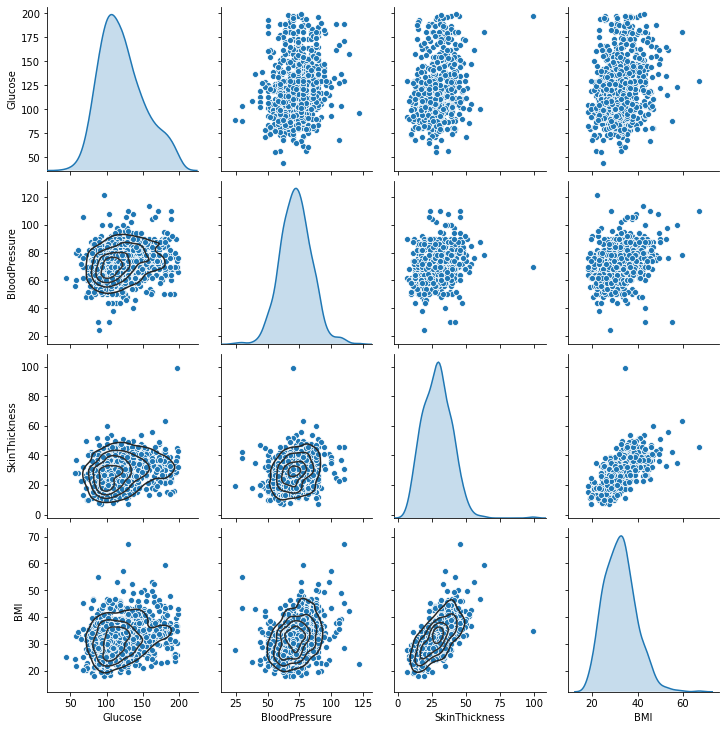

In [26]:
data = diabetes[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']]
g = sns.pairplot(data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

### Sampling Scheme  
  
sampling에 필요한 변수들, 함수들, prior distribution을 구성하는 parameter 기댓값 벡터 mu와 공분산 행렬 Lambda를 initialize하기  
1. $\mu | \Sigma \ \sim \ N(\mu_0, \Lambda_0)$  
2. $\Sigma | \mu \ \sim \ Wis^{-1}(\nu_0, S_0^{-1})$  
- $S_0 = (\nu_0 - d - 1)\Sigma_0$  

In [28]:
n = data.shape[0]       # data 수
p = data.shape[1]       # column 수

S = 100                 # number of iteration (몇 번 update 할건지)

# 자주 쓰는 함수
inv = np.linalg.inv     # 역행렬 구하기
t = np.transpose        # transpose

# priors
## prior for mu ~ N(  ,   )
# mean vector mu_0
mu0 = data.mean().to_numpy()    # column mean

# covariance matrix Lambda_0 : 공분산 행렬 만들기
sd0 = mu0 / 2                   # 왜 이렇게 initialize하는지 모르겠지만 암튼 prior란 원래 나름의 믿음에 따라 주는거니까..
# 아마 actual dataset의 dispersion을 고려하거나 해서 그런게 아닐까..?
L0 = np.ones((p,p))*0.1         # Lambda0 in prior    
di = np.diag_indices(p)         # diagonal index indicator
L0[di] = 1                      # 일단 분산을 1로 init
L0 = L0 * np.outer(sd0, sd0)    # off-diagonal terms

## prior for Sigma ~ Ing-Wishart(   ,   )
nu0 = p + 2                     # first param
S0 = (nu0-p-1)*L0

# misc
Sigma = S0                      # mu의 full conditional posterior를 초기화하는데 필요함
fill_data = data.copy()         # imputate할 dataset copy 만들기

O = data.isna().to_numpy()*1    # indicator variable (결측치 있으면 1, 결측치 없으면 0)

# Naive Imputation
for col in fill_data.columns:
    # 일단 mean imputation
    # 아마 계산 시 nan 있어서 생기는 error를 방지하기 위해서 나이브하게 뭐라도 채워놓고 simulation을 돌린것같음.
    fill_data[col].fillna(fill_data[col].mean(), inplace=True)

**Mean Imputation**  
Pros:  
- Prevent data loss which results in deletion of rows or columns  
- Works well with a small dataset and easy to implement.  
  
Cons:  
- Works only with numerical continuous variables.  
- Can cause data leakage  
- Does not factor the covariance between features.  
  
단순 평균으로만 채우는 건 간편하지만 위와 같은 단점이 있다. 가장 눈여겨 볼 것은 feature 간의 covariance structure를 잃어버리게 된다는 것인데, 무슨 말인지 아래 그림을 통해 확인할 수 있다. 결측치가 많았던 skin thickness의 density가 위의 original data와는 특히 달라졌다!


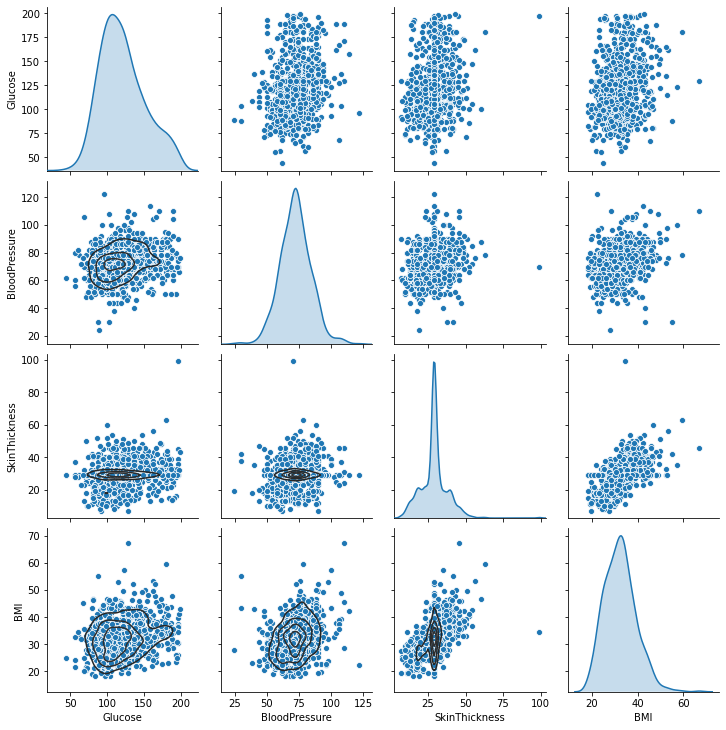

In [29]:
g_naive = sns.pairplot(fill_data, diag_kind="kde")
g_naive.map_lower(sns.kdeplot, levels=4, color=".2")

### Gibbs Sampler Execution  
  
그럼 이런 불상사가 발생하지 않게 feature 간의 covariance structure를 보존하면서 imputation을 해보자.  
  
1. $\mu | \Sigma, y \ \sim \ N(\mu_n, \Lambda_n)$  
- $\Lambda_n^{-1} = \Lambda_0^{-1} + n\Sigma^{-1}$  
- $\mu_n = \Lambda_n(\Lambda_0^{-1}\mu_0 + n\Sigma^{-1}\bar{y})$  
  

2. $\Sigma | \mu, y \ \sim \ Wis^{-1}(\nu_0+n, (S_0 + S_{\mu})^{-1})$  
- $S_{\mu} = \sum(y_i - \mu)(y_i - \mu)^T$
- $S_n = S_0 + S_{\mu}$
  
\- 그리고 결론적으로 각 row를 돌면서 imputation을 할텐데 각각의 행에서 우리가 관찰한 data는 결측치가 아닌 값이 된다.  
$y_{[b]} | y_{[a]}, \theta, \Sigma \ \sim \ MVN(\theta_{b|a}, \Sigma_{b|a})$ where  
- $\theta_{b|a} = \theta_{[b]} + \Sigma_{[b,a]}(\Sigma_{[a,a]})^{-1}(y_{[a]} - \theta_{[a]})$ (7.10)  
- $\Sigma_{b|a} = \Sigma_{[b,b]} - \Sigma_{[b,a]}(\Sigma_{[a,a]})^{-1}\Sigma_{[a,b]}$ (7.11)

In [13]:
for s in range(S):
    # update mu
    ybar = fill_data.mean().to_numpy()
    Ln = inv(inv(L0)+inv(Sigma)*n)        # Lambda_n
    mun = np.matmul(Ln, np.matmul(inv(L0),mu0)+np.matmul(n*inv(Sigma),ybar))       # mu_n
    ## sample mu from full conditional probability given Sigma & y ##
    Mu = stats.multivariate_normal.rvs(mun,Ln,1)      

    # update Sigma
    S_mu = np.matmul(t(fill_data-Mu).to_numpy(),(fill_data-Mu).to_numpy())
    Sn = S0+S_mu
    ## sample Sigma from full conditional probability given mu & y ##
    Sigma = inv(stats.wishart.rvs(nu0+n,inv(Sn),1)

    # update missing data
    for i in range(n):

        # row별로 돌아가면서 1x4 array에 대해서 imputation
        # [T, F, F, T] 등의 형태로 indexing
        a = O[i,]==0        # i번째 row에 결측치 없는 위치
        b = O[i,]==1        # i번째 row에 결측치 있는 위치

        if sum(b)!=0:       # 결측치가 하나라도 있으면 imputation 진행! (결측치 하나도 없으면 sum(b)==0 loop 벗어남)
            # iSa, beta_j에 관한 설명은 좀 어려워서 스킵
            # 궁금하면 FCB p118 (7.10), (7.11) equation 설명 참고
            iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a),sum(a)))
            beta_j = np.matmul(Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa)

            # Covariance Matrix for MVN distribution
            Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b),sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa, Sigma[np.outer(a,b)].reshape(sum(a),sum(b))])
            # Mean Vector for MVN distribution
            mu_j = Mu[b] + np.matmul(beta_j, t(fill_data.iloc[i, a])-Mu[a])

            # MVN 에서 결측치 있는 위치 (b)만 sampling한 값으로 채우기!
            fill_data.iloc[i,b] = stats.multivariate_normal.rvs(mu_j, Sigma_j, 1)

    if s%10==0:
        print(s,"/",S)


0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [69]:
# # debug statement (각각이 어떤 shape, dimension인지 확인하고 싶으면 주석 해제해서 실행해보기)
# ybar = fill_data.mean().to_numpy()
# ybar
# Ln = inv(inv(L0) + inv(Sigma)*n)
# print(Ln.shape)
# mun = np.matmul(Ln, np.matmul(inv(L0), mu0) + np.matmul(n*inv(Sigma), ybar))
# print(mun.shape)
# Mu = stats.multivariate_normal.rvs(mun, Ln, 1)
# print(Mu)

# Sn = S0 + np.matmul(t(fill_data-Mu).to_numpy(), (fill_data-Mu).to_numpy())
# print(Sn)
# Sigma = inv(stats.wishart.rvs(nu0+n, inv(Sn), 1))
# print(Sigma)

# a = O[33,]==0
# print(a)
# b = O[33,]==1
# print(b)
# iSa = inv(Sigma[np.outer(a,a)].reshape(sum(a),sum(a)))
# print(iSa)  
# beta_j = np.matmul(Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa)
# print(beta_j)
# Sigma_j = Sigma[np.outer(b,b)].reshape(sum(b),sum(b)) - np.linalg.multi_dot([Sigma[np.outer(b,a)].reshape(sum(b),sum(a)), iSa, Sigma[np.outer(a,b)].reshape(sum(a),sum(b))])
# print(Sigma_j)
# mu_j = Mu[b] + np.matmul(beta_j, t(fill_data.iloc[3, a])-Mu[a])
# print(mu_j)

In [14]:
# 원래 결측치 있던 data
data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.0,33.6
1,85.0,66.0,29.0,26.6
2,183.0,64.0,NaN,23.3
3,89.0,66.0,23.0,28.1
4,137.0,40.0,35.0,43.1
...,...,...,...,...
763,101.0,76.0,48.0,32.9
764,122.0,70.0,27.0,36.8
765,121.0,72.0,23.0,26.2
766,126.0,60.0,NaN,30.1


In [15]:
# Gibbs Sampler로 결측치를 채운 data
fill_data

,Glucose,BloodPressure,SkinThickness,BMI
0,148.0,72.0,35.000000,33.6
1,85.0,66.0,29.000000,26.6
2,183.0,64.0,35.364524,23.3
3,89.0,66.0,23.000000,28.1
4,137.0,40.0,35.000000,43.1
...,...,...,...,...
763,101.0,76.0,48.000000,32.9
764,122.0,70.0,27.000000,36.8
765,121.0,72.0,23.000000,26.2
766,126.0,60.0,32.024222,30.1


잘 채워졌는지 봅시다!

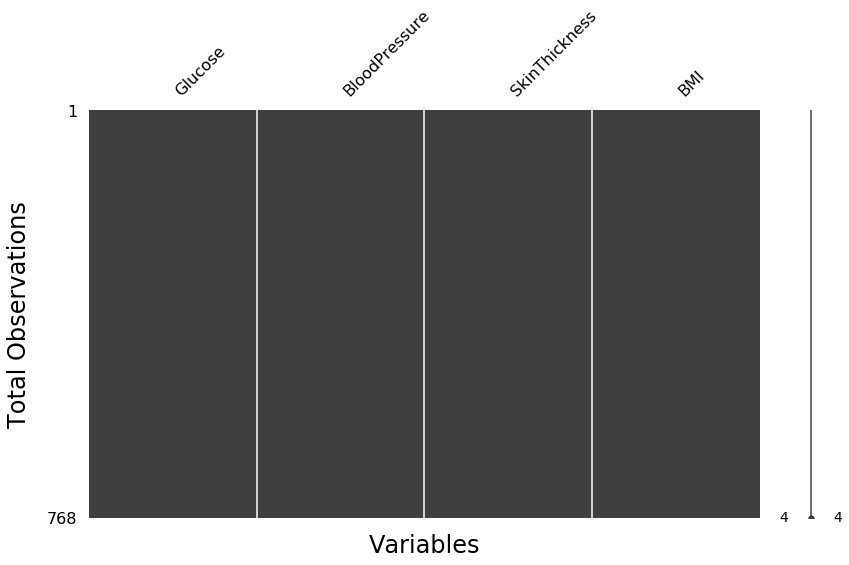

In [16]:
# Visualize the number of missing values as a matrix
fig = msno.matrix(fill_data, inline=False, figsize=(13.33,7.5))

# Add labels
plt.xlabel('Variables', size=24, labelpad=16)
plt.ylabel('Total Observations', size=24, labelpad=16)
plt.tick_params(axis='both', labelsize=16, length=8)

plt.show;

feature간의 covariance structure나 각 feature의 원래 분포도 원 데이터의 분포를 보존하고 있음을 볼 수 있다.

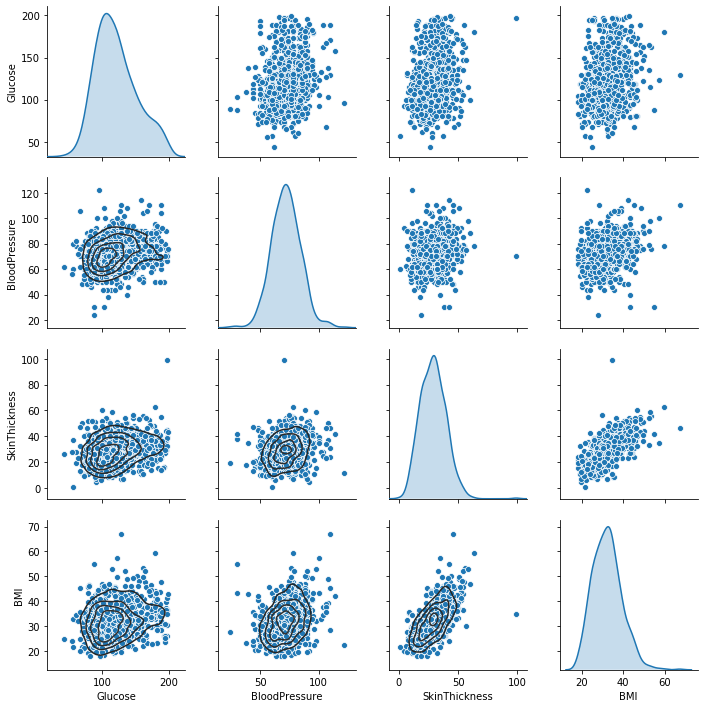

In [17]:
g_filled = sns.pairplot(fill_data, diag_kind="kde")
g_filled.map_lower(sns.kdeplot, levels=4, color=".2")

### Appendix  
당연히 이런 수고스러움을 거칠필요 없이 석박사들이 만들어놓은 패키지에 더 좋은 Imputator들이 있다!  
간단히 소개하자면  
1. `pandas` : 위에서 naive하게 column mean으로 채우는 건 pandas의 `.fillna`를 이용해서 채울 수 있다. 이 외에도 데이터에 시간적인 순서가 있다면 `ffill` 등을 이용해서 직전 값, 직후의 값으로 채우는 방법도 있다.  
2. `sklearn` : `SimpleImputer`가 평균값으로 채우는 방법, `IterativeImputer`가 MICE를 이용해서 채우는 방법이다.  
3. **MICE** (Multivariate Imputation by Chained Equations) : 본 노트북과 같은 방법을 mice라고 부른다. 사실 대부분 패키지의 mice가 bayesian imputation, gibbs sampler의 아이디어를 차용한 것은 맞으나 대부분의 mice implementaion은 frequentist 관점에서 주어진 값들에 대해 regression을 활용하여 결측치를 예측하는 방법으로 구현되어 있는듯하다!  
4. 물론 어떨 때는 걍 drop하는 게 더 좋을 수도 있다!  
  
각각 사용예시는 medium이나 위의 reference에 많으니 궁금한 사람들은 한 번 해보세요!